In [17]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm
import datetime as dt

from vax_sims_LHS_samples import *
from plot_utils import *

In [12]:
def load_sim_output(folder, npoints, lb=0):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(lb, npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        new_row['cornell_inf_10'] = np.quantile(student_infxns + staff_infxns, 0.1)
        new_row['cornell_inf_50'] = np.quantile(student_infxns + staff_infxns, 0.5)
        new_row['cornell_inf_90'] = np.quantile(student_infxns + staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

def residential_regression_student(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'student_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results

def residential_regression_staff(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'staff_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results


In [13]:
def calculate_pessimistic_scenario(results, q=0.99, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']

    invquantile = norm.ppf(q)

    for param in params:
        sd_dict[param] = (UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*beta)
        centre_infections += np.mean(UNCERTAINTY_PARAM_RANGES[param]) * lr_results[param]

    sum_squares_Sigma_1 = 0

    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2

    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)

    mp_pess_scenario = dict()
    for param in params:
        mp_pess_scenario[param] = np.mean(UNCERTAINTY_PARAM_RANGES[param]) + invquantile * pess_direction[param]

    return mp_pess_scenario

In [4]:
LHS_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630458074.2074487', 200)

In [5]:
lr_results = residential_regression_student(LHS_data)
pess_scenario_student = calculate_pessimistic_scenario(lr_results)

In [6]:
def get_direction(pess, centre):
    direction = dict()
    for param in centre.keys():
        direction[param] = pess[param] - centre[param]
    return direction

def generate_new_params(centre, direction, mult):
    new_params = dict()
    for param in centre.keys():
        new_params[param] = centre[param] + mult * direction[param]
    return new_params

def launch_sensitivity_analysis(centre, direction, base_folder, mult_list=np.linspace(-1.1, 1.1, 23), nreps=50, param_modifiers=None):

    points = [generate_new_params(centre, direction, mult) for mult in mult_list]

#     folder_name = '{}/{}/'.format(base_folder, 'pess_sensitivity')
#     os.mkdir(folder_name)

#     fnames = [folder_name + 'mult_{}.dill'.format(mult) for mult in mult_list]

    #import pdb; pdb.set_trace()
    processes = run_sims_new_process(points, base_folder, nreps=nreps, param_modifiers=param_modifiers, wait_for_processes_to_join=False)
    return processes


def run_sims_new_process(points, output_folder, nreps=50, T=112, param_modifiers=None, wait_for_processes_to_join=True):
    idx = 0
    processes = []

    base_seed = np.random.randint(1000000, 10000000)

    for point in points:
        idx += 1
        p = run_new_process(point, idx, output_folder, param_modifiers)
        processes.append(p)

    print("launched {} processes".format(len(processes)))
    if wait_for_processes_to_join:
        for p in processes:
            p.join()
        print("done running processes")
        return processes
    else:
        return processes

def run_new_process(point, idx, output_folder, param_modifiers):
    p = Process(target = run_simulations, args = (point, idx, output_folder, param_modifiers))
    p.start()
    return p

def run_simulations(point, idx, output_folder, param_modifiers):
    T=112
    n=50
    if type(point) == dict:
        point = [point['vax_susc_mult'], point['vax_transmission_mult'], point['contacts_per_day_mult'], point['outside_infection_rate_mult'], point['cases_isolated_per_contact_trace']]
    vax_sim = map_lhs_point_to_vax_sim(point, param_modifiers)
    list_of_infs_by_group = run_multiple_trajectories(vax_sim, T, n)
    with open(output_folder + "lhs_point_{}.dill".format(idx), "wb") as f:
        dill.dump(point, f)
    with open(output_folder + "list_of_infs_by_group_{}.dill".format(idx), "wb") as f:
        dill.dump(list_of_infs_by_group, f)

def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre

def get_timestamp():
    return str(time.time()).split('.')[0]

# Trajectory Level Simulations

In [7]:
def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0]-1].sum()


def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)


def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_trajs_by_group = []
    for group in sim.sims:
        df = group.sim_df
        inf_trajs_by_group.append(get_cum_inf_trajectory(df))
    return inf_trajs_by_group


def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre


def run_multiple_trajs(sim, T, n):
    infs_by_group_list = []
    for _ in range(n):
        infs_by_group = run_multigroup_sim(sim,T)
        infs_by_group_list.append(infs_by_group)
    return infs_by_group_list

In [8]:
base_param_modifiers = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
            'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
            'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
            'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}

In [9]:
# point is either center or pessimistic
delays = list()
for i in range(3):
    print(i)
    param_modifiers = base_param_modifiers.copy()
    param_modifiers['test_delay'] = i
    center_dict = get_centre_point()
    center_point = [center_dict['vax_susc_mult'], center_dict['vax_transmission_mult'], center_dict['contacts_per_day_mult'],
                    center_dict['outside_infection_rate_mult'], center_dict['cases_isolated_per_contact_trace']]
    center_vax_sim = map_lhs_point_to_vax_sim(center_point, param_modifiers)
    center_inf_trajs_by_group = run_multiple_trajs(center_vax_sim, T=112, n=50)
    delays.append(center_inf_trajs_by_group)

0


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


1
2


In [14]:
hd_notify_date_traj = [2,2,11,23,42,57,55,39,31,48]
hd_notify_date_since_aug_28 = [57,55,39,31,48]

start_date = dt.date(2021, 8, 23)
plotting_dates = list()
plotting_dates.append(start_date)
for _ in range(112):
    plotting_dates.append(plotting_dates[-1] + dt.timedelta(days=1))

In [15]:
delay_0_inf_trajs = list()
for idx in range(50):
    delay_0_inf_trajs.append(np.array(delays[0][idx][:-2]).sum(axis=0))

delay_1_inf_trajs = list()
for idx in range(50):
    delay_1_inf_trajs.append(np.array(delays[1][idx][:-2]).sum(axis=0))

delay_2_inf_trajs = list()
for idx in range(50):
    delay_2_inf_trajs.append(np.array(delays[2][idx][:-2]).sum(axis=0))

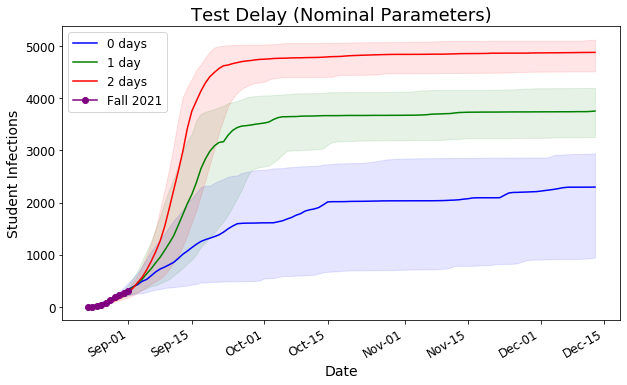

In [19]:
fig = plt.figure(figsize=(10,6))

plt.plot(plotting_dates, np.median(np.array(delay_0_inf_trajs), axis=0), color='blue', label='0 days')
plt.fill_between(x=plotting_dates, y1=np.quantile(np.array(delay_0_inf_trajs), 0.1, axis=0), y2=np.quantile(np.array(delay_0_inf_trajs), 0.9, axis=0), alpha=0.1, color='blue')

plt.plot(plotting_dates, np.median(np.array(delay_1_inf_trajs), axis=0), color='green', label='1 day')
plt.fill_between(x=plotting_dates, y1=np.quantile(np.array(delay_1_inf_trajs), 0.1, axis=0), y2=np.quantile(np.array(delay_1_inf_trajs), 0.9, axis=0), alpha=0.1, color='green')

plt.plot(plotting_dates, np.median(np.array(delay_2_inf_trajs), axis=0), color='red', label='2 days')
plt.fill_between(x=plotting_dates, y1=np.quantile(np.array(delay_2_inf_trajs), 0.1, axis=0), y2=np.quantile(np.array(delay_2_inf_trajs), 0.9, axis=0), alpha=0.1, color='red')

plt.plot(plotting_dates[:len(hd_notify_date_traj)], np.cumsum(hd_notify_date_traj), marker='o', color='purple', label='Fall 2021')

ax = plt.gca()
formatter = mdates.DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(formatter)

# plt.xlim([dt.date(2021,8,23), dt.date(2021,9,15)])
# plt.ylim([0, 2000])

fig.autofmt_xdate()
plt.title('Test Delay (Nominal Parameters)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Student Infections', fontsize=14)
plt.legend()
plt.show()

# Pessimism Level Simulations

In [20]:
def get_direction(pess, centre):
    direction = dict()
    for param in centre.keys():
        direction[param] = pess[param] - centre[param]
    return direction

def generate_new_params(centre, direction, mult):
    new_params = dict()
    for param in centre.keys():
        new_params[param] = centre[param] + mult * direction[param]
    return new_params

def launch_sensitivity_analysis(centre, direction, base_folder, mult_list=np.linspace(-1.1, 1.1, 23), nreps=50, param_modifiers=None):

    points = [generate_new_params(centre, direction, mult) for mult in mult_list]

#     folder_name = '{}/{}/'.format(base_folder, 'pess_sensitivity')
#     os.mkdir(folder_name)

#     fnames = [folder_name + 'mult_{}.dill'.format(mult) for mult in mult_list]

    #import pdb; pdb.set_trace()
    processes = run_sims_new_process(points, base_folder, nreps=nreps, param_modifiers=param_modifiers, wait_for_processes_to_join=False)
    return processes


def run_sims_new_process(points, output_folder, nreps=50, T=112, param_modifiers=None, wait_for_processes_to_join=True):
    idx = 0
    processes = []

    base_seed = np.random.randint(1000000, 10000000)

    for point in points:
        idx += 1
        p = run_new_process(point, idx, output_folder, param_modifiers)
        processes.append(p)

    print("launched {} processes".format(len(processes)))
    if wait_for_processes_to_join:
        for p in processes:
            p.join()
        print("done running processes")
        return processes
    else:
        return processes

def run_new_process(point, idx, output_folder, param_modifiers):
    p = Process(target = run_simulations, args = (point, idx, output_folder, param_modifiers))
    p.start()
    return p

def run_simulations(point, idx, output_folder, param_modifiers):
    T=112
    n=50
    if type(point) == dict:
        point = [point['vax_susc_mult'], point['vax_transmission_mult'], point['contacts_per_day_mult'], point['outside_infection_rate_mult'], point['cases_isolated_per_contact_trace']]
    vax_sim = map_lhs_point_to_vax_sim(point, param_modifiers)
    list_of_infs_by_group = run_multiple_trajectories(vax_sim, T, n)
    with open(output_folder + "lhs_point_{}.dill".format(idx), "wb") as f:
        dill.dump(point, f)
    with open(output_folder + "list_of_infs_by_group_{}.dill".format(idx), "wb") as f:
        dill.dump(list_of_infs_by_group, f)

def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre

def get_timestamp():
    return str(time.time()).split('.')[0]

In [22]:
MULT_RANGE = np.linspace(-1.1, 1.1, 23)

# pess_scenario_student
centre = get_centre_point()

direction = get_direction(pess_scenario_student, centre)

# toggle whether/not to use poisson contact tracing
os.environ['use_poisson_contact_tracing'] = 'True'

# base_folder = './aug_31_student_pess_sensitivity_sims_{}/'.format(get_timestamp())
base_folder = './sept_3_test_delay_sensitivity_sims_{}/'.format(get_timestamp())
os.mkdir(base_folder)

processes = []

# Test policies: [Vax students freq, Unvax students freq]
# 1: [0, 1/7]
# 2: [0, 2/7]
# 3: [1/7, 1/7]
# 4: [1/7, 2/7]
# 5: [2/7, 2/7]
# Nominal: [1/7, 2/7]

base_param_modifiers = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
            'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
            'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
            'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}

# point is either center or pessimistic
for delay in range(3):
    delay_folder = base_folder + 'delay_{}/'.format(delay)
    os.mkdir(delay_folder)
    delay_param_modifiers = base_param_modifiers.copy()
    delay_param_modifiers['test_delay'] = delay
    processes.extend(launch_sensitivity_analysis(centre, direction, delay_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=delay_param_modifiers))

print("finished launching processes, waiting for them to finish")
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

launched 23 processes
finished launching processes, waiting for them to finish


In [26]:
delay_0 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/sept_3_test_delay_sensitivity_sims_1630702167/delay_0', 24, lb=1)
delay_1 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/sept_3_test_delay_sensitivity_sims_1630702167/delay_1', 24, lb=1)
delay_2 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/sept_3_test_delay_sensitivity_sims_1630702167/delay_2', 24, lb=1)

for df in (delay_0, delay_1, delay_2):
    df['mult'] = np.linspace(-1.1, 1.1, 23)
    df['z-score'] = [norm.ppf(0.99) * x for x in np.linspace(-1.1, 1.1, 23)]
    df['quantile'] = [norm.cdf(norm.ppf(0.99) * x) for x in np.linspace(-1.1, 1.1, 23)]

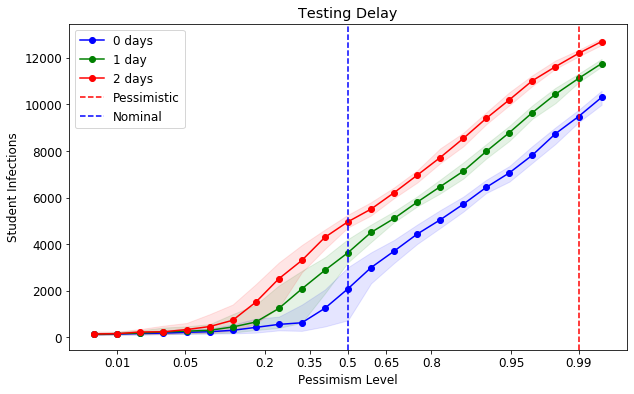

In [28]:
plt.figure(figsize=(10,6))

plt.plot('z-score', 'student_inf_50', marker='o', data=delay_0, label='0 days', color='blue')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=delay_0, color='blue')

plt.plot('z-score', 'student_inf_50', marker='o', data=delay_1, label='1 day', color='green')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=delay_1, color='green')

plt.plot('z-score', 'student_inf_50', marker='o', data=delay_2, label='2 days', color='red')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=delay_2, color='red')

plt.title('Testing Delay')
plt.ylabel('Student Infections')
plt.xlabel('Pessimism Level')

plt.axvline(norm.ppf(0.99), label='Pessimistic', color='red', linestyle = 'dashed')
plt.axvline(0, label='Nominal', color='blue', linestyle = 'dashed')

plotting_quantiles = [0.01, 0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95, 0.99]
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_quantiles)

plt.legend()

plt.show()